<a href="https://colab.research.google.com/github/mandem296/Depression_detection_BERT_model/blob/main/bert2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install datasets
!pip install numpy
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 6.9 MB/s 
     |████████████████████████████████| 182 kB 94.3 MB/s 
     |████████████████████████████████| 7.6 MB 84.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 452 kB 7.8 MB/s 
     |████████████████████████████████| 132 kB 86.4 MB/s 
     |████████████████████████████████| 212 kB 90.1 MB/s 
     |████████████████████████████████| 127 kB 77.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/Dataset/Suicide_Detection.csv',encoding='latin-1',nrows=50000)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
df = df.loc[:, ['post_text','class']]

In [8]:
df

,post_text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"Iâm so lostHello, my name is Adam (16) and I...",suicide
...,...,...
49995,The people at the vet treated me like an adult...,non-suicide
49996,I am ugly thats just it.,non-suicide
49997,"The worst part of life is feeling useless, and...",suicide
49998,Feel like Iâve fucked everything upIt is les...,suicide


In [9]:
np.where(pd.isnull(df))

(array([10972, 10973, 10973, 10974, 10976, 10976, 10977, 10977, 10978,
        10978, 18067, 18068, 18068, 18069, 22519, 22520, 22520, 22521,
        22522, 23003, 23004, 23004, 23005, 23006, 23646, 23647, 23647,
        23648, 38040, 38041, 38041, 38042, 38044, 38044, 38046, 38046,
        38048, 38048, 38050, 38050, 45822, 45823, 45823, 45824, 45825,
        48949, 48950, 48950, 48951, 48952, 48952, 48953, 48953, 48954,
        48954, 48955, 48955, 48956, 48956, 48957, 48957, 48958, 48958,
        48959, 48959, 48960, 48960, 48961, 48961, 48962, 48962, 48963,
        48963, 48964, 48964, 48965, 48965, 48966, 48966, 48967, 48967,
        48968, 48968, 48969, 48969, 48970, 48970, 48971, 48971, 48972,
        48972, 48973, 48973, 48974, 48974, 48975, 48975, 48976, 48976,
        48977, 48977, 48978, 48978, 48979, 48979, 48980, 48980, 48981,
        48981, 48982, 48982, 48983, 48983, 48984, 48984, 48985, 48985,
        48986, 48986, 48987, 48987, 48988, 48988, 48989, 48989, 48990,
      

In [10]:
df.dropna(
    axis=0,
    how='any',
    thresh=None,
    subset=None,
    inplace=True
)

In [11]:
np.where(pd.isnull(df))

(array([], dtype=int64), array([], dtype=int64))

In [16]:
def assignNewLabels(label):
    if label == 'suicide':
        return 1
    else:
        return 0

In [17]:
df['label'] = df['class'].apply(assignNewLabels)

In [18]:
df

,post_text,class,label
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,1
1,Am I weird I don't get affected by compliments...,non-suicide,0
2,Finally 2020 is almost over... So I can never ...,non-suicide,0
3,i need helpjust help me im crying so hard,suicide,1
4,"Iâm so lostHello, my name is Adam (16) and I...",suicide,1
...,...,...,...
49995,The people at the vet treated me like an adult...,non-suicide,0
49996,I am ugly thats just it.,non-suicide,0
49997,"The worst part of life is feeling useless, and...",suicide,1
49998,Feel like Iâve fucked everything upIt is les...,suicide,1


0    24977
1    24927
Name: label, dtype: int64


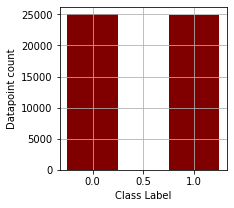

In [19]:
from matplotlib import pyplot as plt
label_counts = df['label'].value_counts()
print(label_counts)
plt.figure(figsize=(3,3))
plt.bar(label_counts.index, label_counts,color ='maroon',
        width = 0.5)
plt.xlabel("Class Label")
plt.ylabel("Datapoint count")
plt.grid()
plt.show()

In [20]:
from sklearn.model_selection import train_test_split

X = df.post_text.values
y = df.label.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=2020)

In [22]:
# Load test data
test_data = pd.read_csv('/content/drive/MyDrive/Dataset/test.csv')

# Keep important columns
test_data = test_data[['post_text']]

# Display 5 samples from the test data
test_data.sample(5)

,post_text
5078,Nigga was almost in tears struggling to open a...
272,@wallswcst STOP THIS AMIE VINE IS ENDING NEXT ...
339,Sending promotional messages to @Luke5SOS and ...
994,me vs trying not to quote all of britts live t...
5047,Ok so malam ni aku akan go through the last sa...


In [24]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: A100-SXM4-40GB


In [25]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
from matplotlib import pyplot as plt
import re

In [27]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [28]:
# Print sentence 0
print('Original: ', X[0])
print('Processed: ', text_preprocessing(X[0]))

Original:  Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began threatening suicide. I have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe I'll come back. I know a lot of people will threaten this in order to get their way, but what happens if she really does? What do I do and how am I supposed to handle her death on my hands? I still love my wife but I cannot deal with getting cheated on again and constantly feeling insecure. I'm worried today may be the day she does it and I hope so much it doesn't happen.
Processed:  Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began threatening suicide. I have tirelessly spent these paat few d

In [29]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

CPU times: user 41.5 s, sys: 3.32 s, total: 44.8 s
Wall time: 44.6 s


In [30]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

In [31]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [32]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [33]:
# Concatenate train data and test data
all_tweets = np.concatenate([df.post_text.values, test_data.post_text.values])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors


Max length:  14248


In [34]:
# Specify `MAX_LEN`
MAX_LEN = 150

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began threatening suicide. I have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe I'll come back. I know a lot of people will threaten this in order to get their way, but what happens if she really does? What do I do and how am I supposed to handle her death on my hands? I still love my wife but I cannot deal with getting cheated on again and constantly feeling insecure. I'm worried today may be the day she does it and I hope so much it doesn't happen.
Token IDs:  [101, 4654, 2564, 8701, 5920, 2890, 13013, 2135, 1045, 2187, 2026, 2564, 2005, 2204, 2138, 2016, 2038, 22673, 2006, 2033, 3807, 1998, 9828, 2000, 2033, 2061, 2172, 2008, 1045, 2031, 2787, 2000, 10214, 2000, 2175, 2067, 2000, 2014, 1012, 2004, 1997, 1037, 2261, 

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [35]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [36]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 40.4 ms, sys: 0 ns, total: 40.4 ms
Wall time: 40.8 ms


In [37]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [38]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [39]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.454960   |     -      |     -     |   7.72   
   1    |   40    |   0.260704   |     -      |     -     |   4.18   
   1    |   60    |   0.230379   |     -      |     -     |   4.18   
   1    |   80    |   0.208737   |     -      |     -     |   4.18   
   1    |   100   |   0.161558   |     -      |     -     |   4.19   
   1    |   120   |   0.139416   |     -      |     -     |   4.18   
   1    |   140   |   0.165505   |     -      |     -     |   4.18   
   1    |   160   |   0.161851   |     -      |     -     |   4.18   
   1    |   180   |   0.174330   |     -      |     -     |   4.18   
   1    |   200   |   0.154344   |     -      |     -     |   4.18   
   1    |   220   |   0.185305   |     -      |     -     |   4.19   
   1    |   240   |   0.103454   |     -      |     -     |   4.18   


In [40]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

AUC: 0.9960
Accuracy: 97.21%


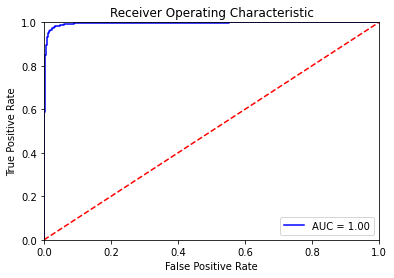

In [41]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [42]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, full_train_dataloader, epochs=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.493124   |     -      |     -     |   4.41   
   1    |   40    |   0.242459   |     -      |     -     |   4.17   
   1    |   60    |   0.242542   |     -      |     -     |   4.18   
   1    |   80    |   0.212285   |     -      |     -     |   4.17   
   1    |   100   |   0.175181   |     -      |     -     |   4.18   
   1    |   120   |   0.179016   |     -      |     -     |   4.18   
   1    |   140   |   0.196961   |     -      |     -     |   4.17   
   1    |   160   |   0.142458   |     -      |     -     |   4.18   
   1    |   180   |   0.202219   |     -      |     -     |   4.17   
   1    |   200   |   0.146098   |     -      |     -     |   4.19   
   1    |   220   |   0.117498   |     -      |     -     |   4.17   
   1    |   240   |   0.114964   |     -      |     -     |   4.18   


In [43]:
test_data.sample(5)

,post_text
2458,RT @RelatableQuote: It's 2016. The future is h...
2228,@vilehag WHERE CAN I WATCH THIS???
5555,Minnesota Office of the Secretary of State : S...
3078,Real men don’t get #depression’ stereotype: ht...
263,Thought @AlexAllTimeLow was gonna show up on T...


In [44]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_data.post_text)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [45]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.9
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted depressive tweets: ", preds.sum())

Number of tweets predicted depressive tweets:  539


In [46]:
output = test_data[preds==0]
output

,post_text
0,Elle and Eve https://t.co/WjzJ52qiE9
1,RT @JamilSmith: DIdn’t @realDonaldTrump say th...
2,RT @Photos_KP: Beautiful rare white lions 😀😀😀\...
3,@vnndrws the man is actually a woman?
4,RT @5SOS: The last song ❤️ (sorry about the sh...
...,...
6694,@snarkomarco nighty night snark
6695,*dms no rates*
6696,@BattleMonkeyz it's too wet to run here. :(
6697,Team #IdrisElba ♡ http://t.co/PBvxAoS9YG


In [47]:
output_non = test_data[preds==1]
output_non

,post_text
5,Depression Treatments: Non-invasive depression...
8,@lucas_heitkamp right?😂
14,Astaga. Why is everything arriving today ahsia...
15,Haiz. Relapsing back. This is not good.
32,So much alcohollllllll
...,...
6657,Juuuuuumad? @saveahoejoe https://t.co/SrjOAgMzyd
6666,opportunitytaxinsured https://t.co/IwHDB3BIHj
6667,Idk man. I'm at that point where if people wan...
6677,"Anxiety, Stress, And Dizziness? http://bit.ly/..."


In [48]:
import pickle

In [49]:
with open('depressionModel.pkl', 'wb') as fid:
    pickle.dump(bert_classifier, fid)
#pickle.dump(bert_classifier, open('transform.pkl', 'wb'))

# Open the pickle file and load its content
with open('depressionModel.pkl', 'rb') as file:
  depressionModel = pickle.load(file)

In [51]:
weights=depressionModel.state_dict()

In [50]:
predictors=bert_predict(depressionModel, test_dataloader)
                        # Compute predicted probabilities on the test set


# Get predictions from the probabilities
threshold = 0.9
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted depressive tweets: ", preds.sum())

Number of tweets predicted depressive tweets:  539


In [52]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.8 MB 7.3 MB/s 
     |████████████████████████████████| 55 kB 4.8 MB/s 
     |████████████████████████████████| 278 kB 90.2 MB/s 
     |████████████████████████████████| 2.3 MB 68.6 MB/s 
     |████████████████████████████████| 84 kB 4.8 MB/s 
     |████████████████████████████████| 56 kB 6.6 MB/s 
     |████████████████████████████████| 106 kB 91.9 MB/s 
     |████████████████████████████████| 84 kB 4.1 MB/s 
     |████████████████████████████████| 64 kB 3.7 MB/s 
     |████████████████████████████████| 80 kB 12.0 MB/s 
     |████████████████████████████████| 68 kB 9.5 MB/s 
     |████████████████████████████████| 58 kB 8.1 MB/s 
     |████████████████████████████████| 50 kB 8.2 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4711 sha256=e82cd669e35b0a4731981894a5a06f46c42b932499150ae7e069a9067b63f66f
  Stored in direc

In [53]:
import gradio as gr

In [64]:
!pip install snscrape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 59 kB 4.4 MB/s 


In [89]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

query="Tristanbasinang until:2022-12-24"

tweets = []
limits = 50
for tweet in sntwitter.TwitterSearchScraper(query).get_items():
  #print(vars(tweet))
  #break
  if len(tweets) == limits:
    break
  else:
    tweets.append([tweet.content])

df1 = pd.DataFrame(tweets, columns=['post_text'])
df1.to_csv('/content/drive/MyDrive/Dataset/userDataset.csv')

In [87]:
cat="i am"
cat

'i am'

In [85]:
query1 = print('"{} until:2022-12-24"'.format(username))
query=query1

"Tristanbasinang until:2022-12-24"


In [71]:
df1

,post_text
0,@AsbelFar @PokemonGoApp Request sent from same...
1,⚠️⚠️⚠️⚠️⚠️⚠️⚠️\nThis person changed their @!\n...
2,@russellnohelty @EnglishmanSDCC @HenryBarajas ...
3,sexy new username
4,What kind of a username is 'hrkmras'? Did you ...
5,@wundergumi Top haitham and btm kvh! It's how ...
6,"se que no estoy en su numero 1, pero para mí e..."
7,🥲🥲🥲🥲🥲 https://t.co/O1fwnMRjCj
8,"This isn’t fair, they deserve to just have fun..."
9,Add me on Snapchat! Username: tania_bass22 htt...
